building grid stimsets for use with DMD. Sequence optimization is based on solution to traveling salesman problem discussed here: https://stackoverflow.com/questions/25585401/travelling-salesman-in-scipy
Thanks to the Stack Overflow community.

In [1]:
from stimset_builder import *

In [2]:
##Create a sequence of rectangular stimuli corresponding to specified grid dimension.
##Plotted in 1024x1024 'camera space' with margins that correspond to borders of DMD (manually measured and spec'd in code)
grid_stims = draw_all_grid_rects(n_cols=12, n_rows=10)

In [3]:
##make an array of center of masses
coms = image_sequence_com(grid_stims)
coms = np.array(coms)

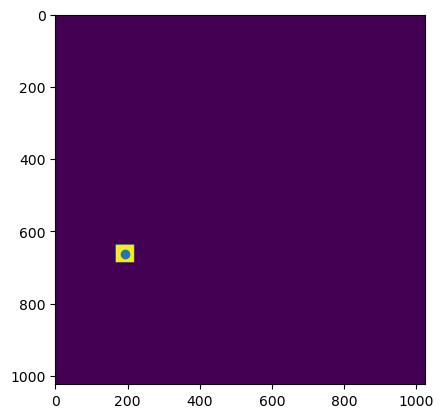

In [4]:
i=100
plt.imshow(grid_stims[:,:,i].T)
plt.scatter(coms[i][0], coms[i][1])

In [5]:
## design photostim order to minimize distance (i.e. traveling salesman)
## will not use this, except for comparison to maximized distance order
short_route = two_opt(coms,0.001)


In [6]:
def plot_route(route, coms):
    route_ix=[]
    for i in np.arange(len(route)):
        route_ix.append(list(route).index(i))

    new_route_order = np.concatenate((np.array([coms[route[i]] for i in range(len(route))]),np.array([coms[0]])))
    fig, ax = plt.subplots()
    sc = ax.scatter(coms[:,0],coms[:,1], c=route_ix, cmap='brg', zorder=5, s=100)
    # Plot the path.
    ax.plot(new_route_order[:,0],new_route_order[:,1], zorder=0, c='black', lw=1)
    cbar = fig.colorbar(sc)
    cbar.set_label('stim order', rotation=270)
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    
    plt.show()
    # Print the route as row numbers and the total distance travelled by the path.
    print("Route: " + str(route) + "\n\nDistance: " + str(path_distance(route,coms)))

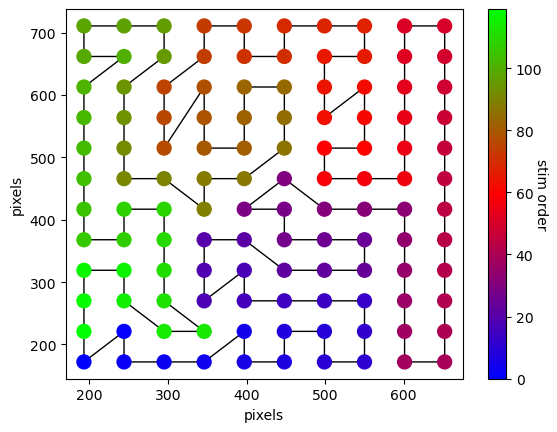

Route: [  0  11   1   2   3  14   4   5  15  16   6   7  17  27  26  25  24  34
  23  33  43  44  35  36  37  47  46  45  55  54  65  56  57  58  48  38
  28  18   8   9  19  29  39  49  59  69  79  89  99 109 119 118 108  98
  88  78  68  67  66  76  77  87  97  86  96 106 107 117 116 115 105 104
 114 113 103  92  82  72  93  83  73  74  84  94  95  85  75  64  63  53
  62  61  71  81  91 102 112 111 110 100 101  90  80  70  60  50  40  41
  51  52  42  32  22  13  12  21  31  30  20  10]

Distance: 6319.623705554674


In [7]:
plot_route(short_route, coms)

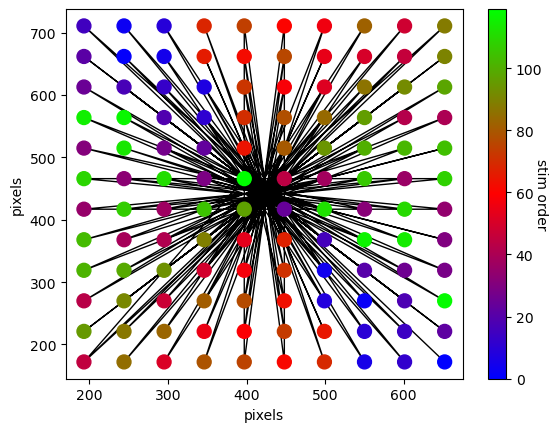

Route: [  9 101  27 111  36 102   7  93  26 112  17  83   8  92  18 110  46  91
  28  82  37 100  19  73  55  90  38  72  39  63  49  70  57  61  59  50
  68  52  66  41  89  42  88  20  65   0 108  22 118  33 107   2  96  44
 106  13 116  34  95  14 115   5 104  25  74  16 103  45 113   6  84  35
  94  15 114   4 105  24  85   3  75  23 117  12  86   1  97  11 119  43
 109  21  98  32  76  10  87  54  99  31  77  30  78  40  79  53  67  51
  69  60  58  62  56  71  48  80  47  81  29  64]

Distance: 50307.65488612374


In [8]:
long_route = two_opt_long(coms,0.0001)

plot_route(long_route, coms)

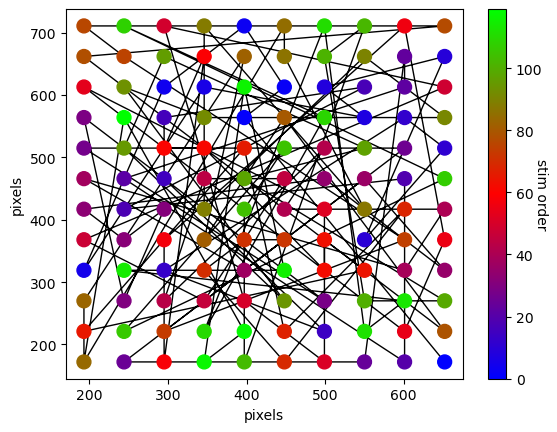

Route: [  9  84  95 114  92  30  93  87  96 109  47  79  88  32  16  62  82  97
  51  68   8  61  98 108   7   1  78  70  26  80  21  52  41  50  66  39
  67  34  60  38  59  55  76  22  63  65  23  40  99 112  24   6  56  90
  18  49 118  42   2 103  72  73  36  46  37  10  74  15  58   5  33  44
  45  12  48 101 110 119 100  19  85  43 104  20   0 115 105  57 113  53
 107  89  83  91  25  71 102  77  64  29  27 106 117   4  54  75  11  69
 111  86  13 116  17  28  31  35  94   3  14  81]

Distance: 33607.94293775506


In [9]:
##long route tends to take long steps back and forth so that point n+2 is near point n. Try to avoid...
non_adj_route = two_opt_one_two_step(coms, 0.0001)

plot_route(non_adj_route, coms)

In [10]:
##have not explicitly avoided having adjacent pixels in long route. May add in future. See how did by comparing min. distances.
min_dist_short_route = np.min(distances_all_steps(short_route, coms))
min_dist_long_route = np.min(distances_all_steps(long_route, coms))
min_dist_non_adj = np.min(distances_all_steps(non_adj_route, coms))
print ("min dist short path: %s pixels", (min_dist_short_route))
print ("min dist long path: %s pixels", (min_dist_long_route))
print ("min dist non adj: %s pixels", (min_dist_non_adj))

min dist short path: %s pixels 49.0
min dist long path: %s pixels 141.4496376806954
min dist non adj: %s pixels 49.0


Text(0.5, 0, 'distance n to n+2')

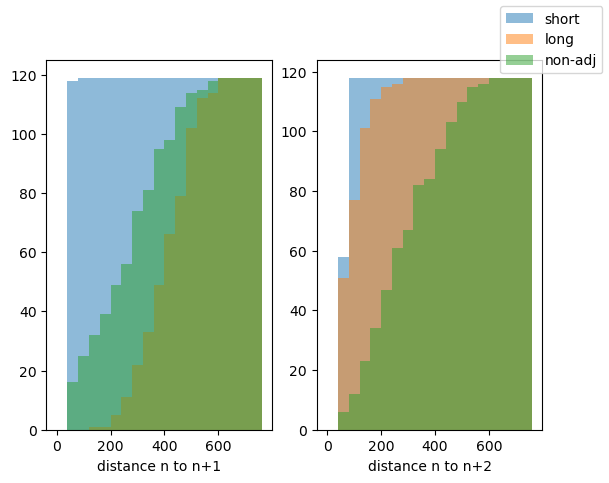

In [11]:
route_list = [short_route, long_route, non_adj_route]
label_list = ["short", "long", "non-adj"]
bins = np.arange(0, 800, 40)
fig, axs = plt.subplots(1, 2)
for route, label in zip(route_list, label_list):
    
    axs[0].hist(distances_all_steps(route, coms), cumulative=True, alpha=0.5, label=label, bins=bins)
    axs[1].hist(distances_n_steps(route, coms, n_steps=2), cumulative=True, alpha=0.5, bins=bins)
fig.legend()
axs[0].set_xlabel('distance n to n+1')
axs[1].set_xlabel('distance n to n+2')

In [12]:
sequence_dict = {}
sequence_dict['raster'] = np.arange(len(long_route))
sequence_dict['long_path'] = long_route
sequence_dict['non_adj'] = non_adj_route
sequence_dict['default'] = non_adj_route

In [13]:
grid_12by10 = StimSequenceSet(grid_stims, "grid_12by10", sequence_dict)

In [14]:
import pickle

In [15]:
with open(f'grid_12by10.pickle', 'wb') as file:
    pickle.dump(grid_12by10, file) 

In [16]:
##test pickle loading
with open(f'grid_12by10.pickle', 'rb') as file2:
    grid_new = pickle.load(file2)

In [17]:
grid_new.name

'grid_12by10'

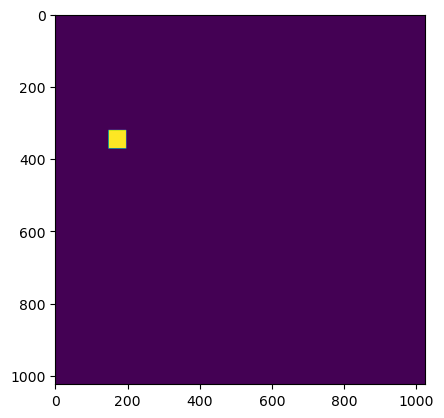

In [18]:
stim_pats = grid_new.image_sequence
plt.imshow(stim_pats[:,:,3])

In [19]:
coarse_grid = draw_all_grid_rects(n_cols=6, n_rows=5)

In [20]:
coms = image_sequence_com(coarse_grid)
coms = np.array(coms)

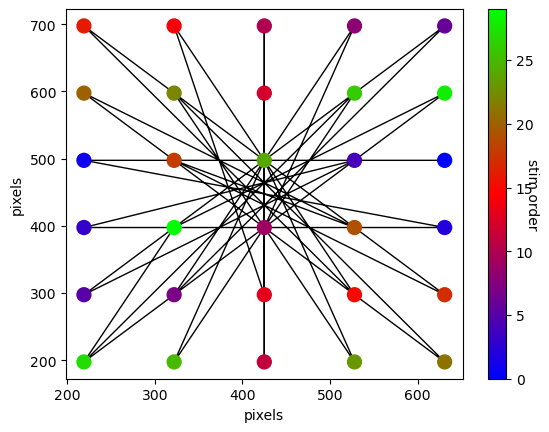

Route: [19 15 14 10 18  5 29  6 28 12 27  2 22  7 26  8 25  9 16 13 20  4 21  3
 17  1 23  0 24 11]

Distance: 12581.888219604036


In [21]:
long_route = two_opt_long(coms,0.0001)

plot_route(long_route, coms)

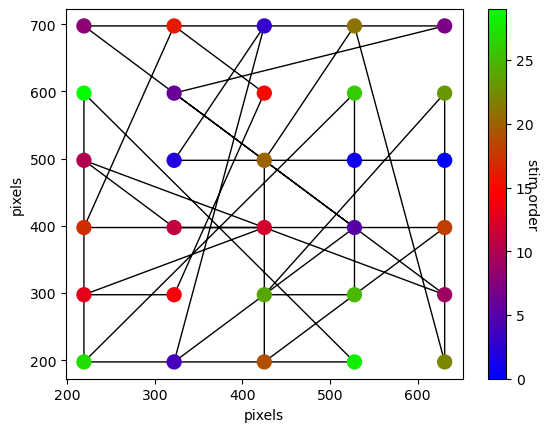

Route: [19 18 16 27  1 13 21 29 25  9 15 11 12  5  6 22 26 10 14  2 17 28  4 24
  7  8 23  0  3 20]

Distance: 9389.533113390346


In [22]:
non_adj_route = two_opt_one_two_step(coms, 0.0001)
plot_route(non_adj_route, coms)

In [23]:
sequence_dict = {}
sequence_dict['raster'] = np.arange(len(long_route))
sequence_dict['long_path'] = long_route
sequence_dict['non_adj'] = non_adj_route
sequence_dict['default'] = non_adj_route

In [24]:
grid_6by5 = StimSequenceSet(coarse_grid, "grid_6by5", sequence_dict)

In [25]:
with open(f'grid_6by5.pickle', 'wb') as file:
    pickle.dump(grid_6by5, file) 

In [26]:
def draw_all_grid_hex(n_cols, n_rows, img_w=1024, img_h=1024):
    n_stims = n_cols * n_rows
    grid_stims = np.zeros((img_w, img_h, n_stims), dtype = np.uint8)
    grid_i = 0
    for ic in np.arange(n_cols):
        for ir in np.arange(n_rows):
            stim = draw_hex(n_cols, n_rows, ic, ir)
            grid_stims[:, :, grid_i] = stim
            grid_i += 1
    return grid_stims

In [27]:
hex_grid_stims = draw_all_grid_hex(12, 10)

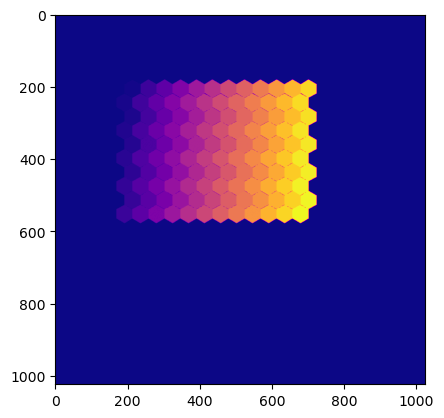

In [28]:
##check that hexys drawn as (h)expected
n_col, n_row = 12, 10
n_stims = n_col*n_row
hex_grid_stims = draw_all_grid_hex(n_col, n_row)
hex_grid_sum = np.zeros((1024,1024))
for i in np.arange(n_stims):
    hex_i = np.zeros((1024, 1024))
    hex_i = hex_grid_stims[:,:,i]
    hex_i = hex_i/255*(i+1)
    hex_i = hex_i.clip(max=255)
    
    hex_grid_sum += hex_i
    
plt.imshow(hex_grid_sum, cmap='plasma')

In [29]:
coms = image_sequence_com(hex_grid_stims)
coms = np.array(coms)

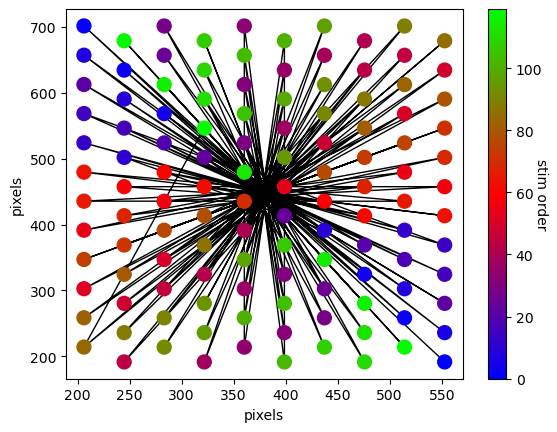

Route: [  9 110  18 101  37  82  19 100  28  91  46  71  48  70  49  80  39  81
  38  72  47  90  29  73  55 102  26 112  16  74  35  94  15 114   4 105
  24  85   3 106  44 117  33 107   1 108  22  76  21 109  32  88  20  65
  40  68  52  69  61  56  62  57  63  59  60  58  50  67  51  79  54  89
  41  77  30  78  42  66  53  99  31  87  10  98   0 119  43  97  11 118
  12  86   2  96  23  75  13 116  34  95  14 115   5 104  25  84  45 113
   6 103   7  93  17  64  36  92  27 111   8  83]

Distance: 42311.7114901062


In [30]:
long_route = two_opt_long(coms,0.0001)


plot_route(long_route, coms)

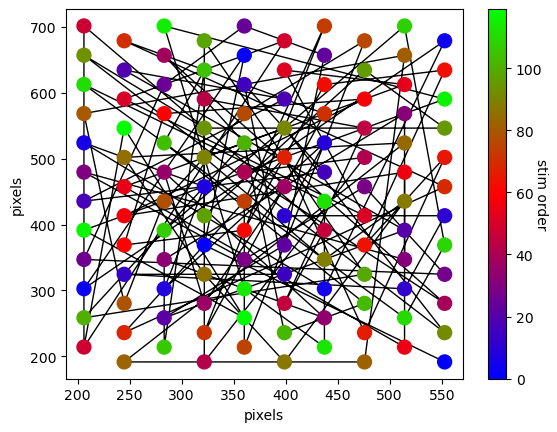

Route: [  9  43 104  20 119  26  70  63  22  76  55  59  28  31  35  94  66  50
  95 101  48  12  45 106 114  92  30  39  67  34  60  38  88  32  16  62
  23  65 102  29  64  77   3  93  87  25  46 110   0 115  91  57 105  98
  61   8  68  51  97  82  41  44  96 109  47  79  17  75  11  69 111  86
  13 116  54   4 117  84  52  21  80 108   7   1  78  71  33   5  58  36
  73  85  19 100  83  89 107  53 113  37  10  74  15  27  72 103   2  42
 118  49  18  90  56   6  24 112  99  40  14  81]

Distance: 31674.499139995896


In [31]:
non_adj_route = two_opt_one_two_step(coms, 0.0001)
plot_route(non_adj_route, coms)

In [32]:
sequence_dict = {}
sequence_dict['raster'] = np.arange(len(long_route))
sequence_dict['long_path'] = long_route
sequence_dict['non_adj'] = non_adj_route
sequence_dict['default'] = non_adj_route

In [33]:
hex_12by10 = StimSequenceSet(hex_grid_stims, "hex_12by10", sequence_dict)

In [34]:
with open(f'hex_12by10.pickle', 'wb') as file:
    pickle.dump(hex_12by10, file) 

In [35]:
hex_grid_stims = draw_all_grid_hex(18, 15)

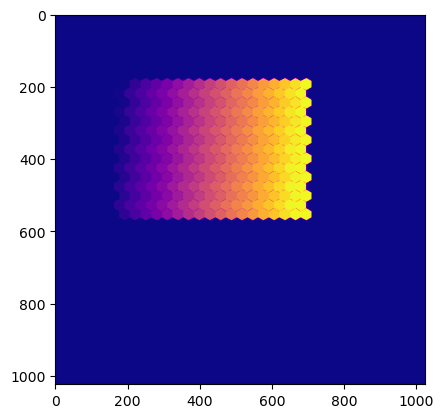

In [36]:
##check that hexys drawn as (h)expected
n_col, n_row = 18, 15
n_stims = n_col*n_row
hex_grid_stims = draw_all_grid_hex(n_col, n_row)
hex_grid_sum = np.zeros((1024,1024))
for i in np.arange(n_stims):
    hex_i = np.zeros((1024, 1024))
    hex_i = hex_grid_stims[:,:,i]
    hex_i = hex_i/255*(i+1)
    hex_i = hex_i.clip(max=255)
    
    hex_grid_sum += hex_i
    
plt.imshow(hex_grid_sum, cmap='plasma')

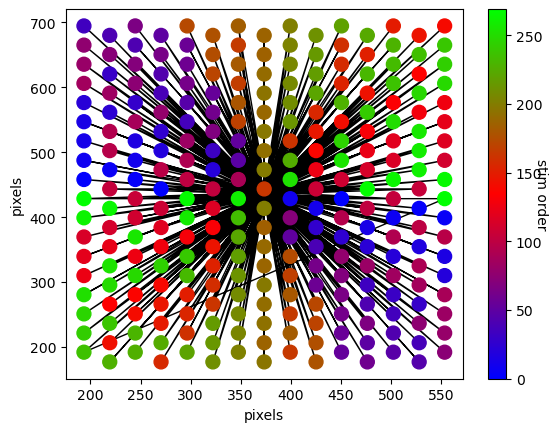

Route: [138 130 135 133 137 119 151 117 150 128 152 129 165 116 180  89 167 103
 168  74 155  87 195 101 196 100 183 114 197  58 226  57 170  71 255  42
 184  28 213  99 256  56 242  27 228  13 199  12 156  26 258  98 171  10
 215  25 244  69 229  11 200  40 214  84 243  55 257  41 185  70 227 113
 241  14 212  43 240  85 198  29 225  86 169  44 211  72 210  73 182  59
 141  88 154 102 181 115 166 104 153 118 139 131 140 132 136 148 122 144
 123 145 107 164 106 161  90 162 125 179 108 177  75 194  91 176  60 159
  77 209  93 208  94 191 110 207  46 238  47 174  63 269  32 190  16 221
  95 268  48 189  33 267  49 251  80 220  34 204   3 235  65 250  19 173
  50 142   8 246  38 216  68 186  39 230  54 259  83 245  24 260   9 201
  53 231  23 261 112 247  22 262  82 202  97 232  52 172  37 217   7 187
  67 157 127 263   6 248  21 233  36 218  51 203   5 264  66 188  20 249
  35 234  81 265   4 219  96 266  18 158   2 205   1 252  17 236  64 237
 111 253   0 222  31 254  79 206  15 239  78

In [37]:
coms = image_sequence_com(hex_grid_stims)
coms = np.array(coms)
long_route = two_opt_long(coms,0.0001)
plot_route(long_route, coms)

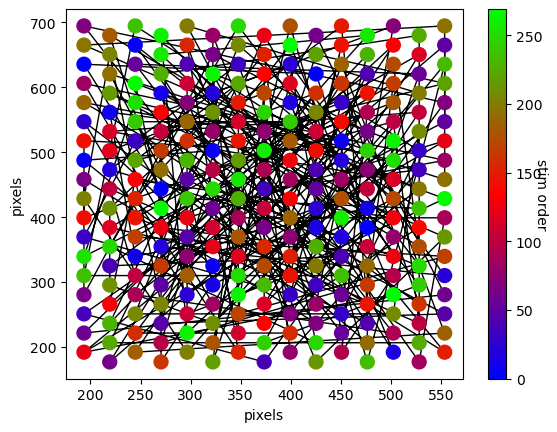

Route: [138 225 234 116 242 170 150  80 175 196  77 131 213  65 114  12 203 100
 151 215 160  93  74 233 129  49 180  40 178 205  53  90 167 231  69 163
 142  30   7  85  76 236 159 229  41  94  33  44 139  63 254 194 144  25
 227 238  55 125  15  59 264   1 112 191 245  45 135  39 255 209  38 199
 267 161  98  79 187   8 102 185 260  54 145 164 210  50 143  13 119 111
  47  27 157 206  10  72  18 155 192  43 136  62 146 208 183 127 101  34
 214 189 110  21 186 181 147  52 253 106  81 218 166  95   0 179 109 262
  87 108 158 117 137  46 252 128 198 232  37 118 190 105 165 174 250  68
 171 221 107  56 265 201  14  83 247 122   6 244  97  23  17 219 169  58
 220   3  78 168  71 222  92  89  36 217 132  82 237 103 130 263  20  96
 207 173 256  64   2  29 235 113 184 195  86  26 153 226 149 269 240 148
  84 259 223   4 120 241  48 204 246  32  42 193  35  61 121 200   9 104
 211 156   5 249 224 152 216  16  28 268 228 126  99 251  31 154  67 239
  11  70  60 257 133 124 182 188  73  22 176

In [38]:
non_adj_route = two_opt_one_two_step(coms, 0.0001)
plot_route(non_adj_route, coms)

In [39]:
sequence_dict = {}
sequence_dict['raster'] = np.arange(len(long_route))
sequence_dict['long_path'] = long_route
sequence_dict['non_adj'] = non_adj_route
sequence_dict['default'] = non_adj_route
hex_18by15 = StimSequenceSet(hex_grid_stims, "hex_18by15", sequence_dict)

In [40]:
with open(f'hex_18by15.pickle', 'wb') as file:
    pickle.dump(hex_18by15, file) 